# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**:  
They are similar in the sense that they both use shared weights in the network.
They are different because CNNs operate on a fixed-size input and produce a fixed-size output. In contrast to that, RNNs operate on arbitrary-length sequences, output arbitrary-length sequences and preserve the context in the memory over time.

**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  
- Exploding gradients:
    - use shrinkage methods for recurrent weights
    - use gradient clipping when the norm exceeds a certain threshold
- Vanishing gradients:
    - use orthogonal initialization of weights
    - use specially designed architectures that solve this problem (e.g. LSTM)


## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [52]:
from torch.nn.parameter import Parameter
from torch import Tensor, zeros, randn

class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        # initialize required parameters / layers
        # Forget
        self.W_forget = Parameter(randn(self.hidden_size, self.hidden_size + self.input_size))
        self.b_forget = Parameter(randn(self.hidden_size))
        # Input
        self.W_input = Parameter(randn(self.hidden_size, self.hidden_size + self.input_size))
        self.b_input = Parameter(randn(self.hidden_size))
        # Candidate
        self.W_candidate = Parameter(randn(self.hidden_size, self.hidden_size + self.input_size))
        self.b_candidate = Parameter(randn(self.hidden_size))
        # Output
        self.W_output = Parameter(randn(self.hidden_size, self.hidden_size + self.input_size))
        self.b_output = Parameter(randn(self.hidden_size))
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        # START TODO #############
        h, C = hx
        h_x_concat = torch.cat([h, x], dim=1)
        # Forget
        forget = torch.sigmoid(
            F.linear(h_x_concat, self.W_forget, self.b_forget)
        )
        # Input
        input = torch.sigmoid(
           F.linear(h_x_concat, self.W_input, self.b_input)
        )
        
        # Candidate
        C_tilde = torch.tanh(
            F.linear(h_x_concat, self.W_candidate, self.b_candidate)
        )
        
        # New internal cell state (C)
        C = forget * C + input * C_tilde

        # New hidden state
        o = torch.sigmoid(
            F.linear(h_x_concat, self.W_output, self.b_output)
        )
        h = o * torch.tanh(C)
        return h, C
        # END TODO #############
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        batch_size = x.shape[0]
        return (
            torch.zeros(batch_size, self.hidden_size),
            torch.zeros(batch_size, self.hidden_size)
        )
        # END TODO #############

In [53]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)
        # START TODO #############
        outputs = []
        # iterate over the sequence and apply the LSTM
        seq_len, batch_size, input_size = x.shape
        for idx in range(seq_len):
            element = x[idx]
            hx = LSTMCell.forward(self, element, hx)
            last_hidden_state, last_internal_state = hx
            outputs.append(last_hidden_state)

        output_stacked_hidden = torch.stack(outputs, 0)
        return output_stacked_hidden, (last_hidden_state, last_internal_state)
        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [54]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()


epoch: 0, loss:2.8016974925994873
test accuracy: 0.03
epoch: 10, loss:7.532863616943359
test accuracy: 0.02
epoch: 20, loss:7.511816501617432
test accuracy: 0.04
epoch: 30, loss:7.499151706695557
test accuracy: 0.04
epoch: 40, loss:7.4723219871521
test accuracy: 0.03
epoch: 50, loss:4.98483943939209
test accuracy: 0.05
epoch: 60, loss:4.982463836669922
test accuracy: 0.05
epoch: 70, loss:4.978940963745117
test accuracy: 0.02
epoch: 80, loss:4.977312088012695
test accuracy: 0.02
epoch: 90, loss:4.976262092590332
test accuracy: 0.02
epoch: 100, loss:4.976161956787109
test accuracy: 0.02


## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

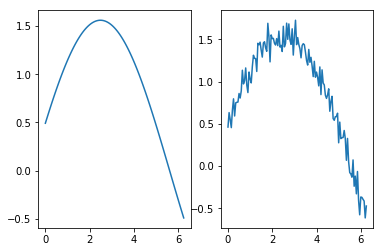

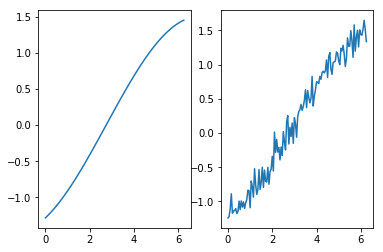

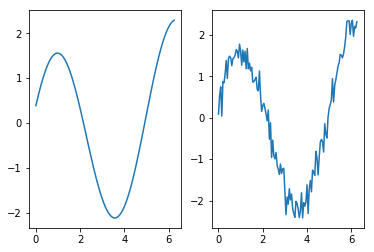

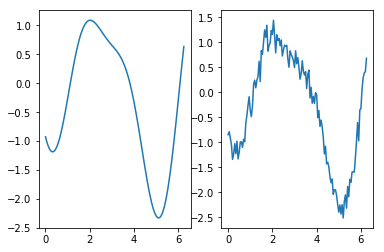

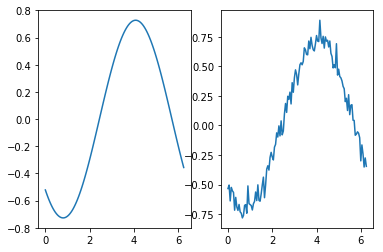

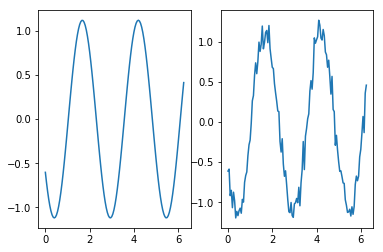

In [5]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
fs = sample_sine_functions(6)
xs = np.arange(0, 2 * np.pi, 0.05)
for f in fs:
    ys = f(xs)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.subplot(1, 2, 2)
    plt.plot(xs, noisy(ys))
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (sequence_length, batch_size, hidden_size) followed by a Linear layer which takes a (sequence_length, batch_size, hidden_size) vector as input and outputs a tensor with shape (sequence_length, batch_size, 1).


To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [45]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        # START TODO #############
        self.lstm1 = nn.LSTM(1, hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.interval zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        # LSTM
        padding = torch.zeros(self.shift, *x.shape[1:])
        x_padded = torch.cat([x, padding], dim=0) # Pad
        output_stacked_hidden, hx = self.lstm1(x_padded)
        
        # LSTM
        x_cut = output_stacked_hidden[self.shift:] # Cut
        output_stacked_hidden, hx = self.lstm2(x_cut, hx)
        
        # Linear
        out = self.linear(output_stacked_hidden)
        return out
        # END TODO #############

In [46]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

In [47]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    num_samples = train_sequences.shape[0]
    for epoch in range(num_epochs):
        # START TODO #############
        for batch_idx in range(num_samples // batch_size):
            optimizer.zero_grad()
            batch = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            output = model(batch)
            labels = train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss = loss_fn(labels, output)
            loss.backward()
            optimizer.step()
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:998.956787109375
epoch: 0, validation loss:4332.1240234375


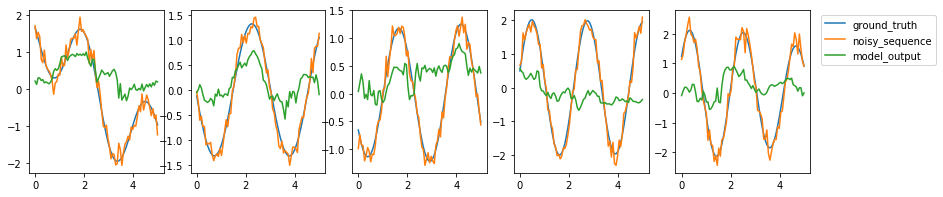

-551.2215% of noise removed.
epoch: 1, train loss:933.8080444335938
epoch: 1, validation loss:3601.621337890625
epoch: 2, train loss:760.021484375
epoch: 2, validation loss:3195.1396484375
epoch: 3, train loss:777.3141479492188
epoch: 3, validation loss:2933.835693359375
epoch: 4, train loss:738.587890625
epoch: 4, validation loss:3000.04052734375
epoch: 5, train loss:606.2570190429688
epoch: 5, validation loss:2758.79443359375
epoch: 6, train loss:597.8466796875
epoch: 6, validation loss:2653.664306640625
epoch: 7, train loss:622.2367553710938
epoch: 7, validation loss:2732.08349609375
epoch: 8, train loss:612.3335571289062
epoch: 8, validation loss:2806.77685546875
epoch: 9, train loss:598.3668823242188
epoch: 9, validation loss:2934.945068359375
epoch: 10, train loss:612.5791625976562
epoch: 10, validation loss:3014.357421875


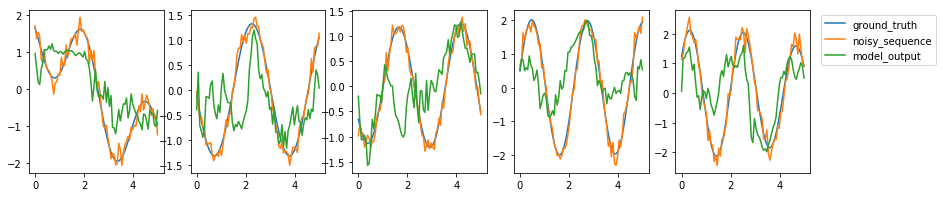

-441.0049% of noise removed.
epoch: 11, train loss:685.4338989257812
epoch: 11, validation loss:3011.52001953125
epoch: 12, train loss:595.6901245117188
epoch: 12, validation loss:2801.927001953125
epoch: 13, train loss:613.4916381835938
epoch: 13, validation loss:2958.91796875
epoch: 14, train loss:673.5416259765625
epoch: 14, validation loss:2745.166259765625
epoch: 15, train loss:598.7141723632812
epoch: 15, validation loss:2730.0283203125
epoch: 16, train loss:623.8541870117188
epoch: 16, validation loss:2791.998046875
epoch: 17, train loss:653.7080078125
epoch: 17, validation loss:2718.3671875
epoch: 18, train loss:620.1573486328125
epoch: 18, validation loss:2690.37841796875
epoch: 19, train loss:589.249755859375
epoch: 19, validation loss:2642.801025390625
epoch: 20, train loss:574.6881713867188
epoch: 20, validation loss:2729.45849609375


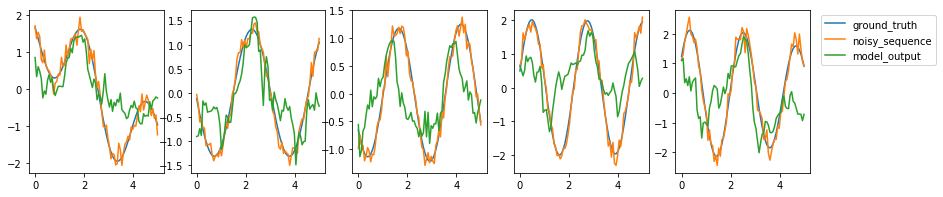

-426.4684% of noise removed.
epoch: 21, train loss:594.231689453125
epoch: 21, validation loss:2917.989501953125
epoch: 22, train loss:550.5699462890625
epoch: 22, validation loss:2887.425537109375
epoch: 23, train loss:584.35205078125
epoch: 23, validation loss:2787.593994140625
epoch: 24, train loss:647.126220703125
epoch: 24, validation loss:3036.894287109375


KeyboardInterrupt: 

In [42]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration | 47.9692%               |
| configuration 1 | 50.0728%               |
| configuration 2 | 50.3355% | 
| configuration 3 | 51.0243% |

epoch: 0, train loss:596.4739379882812
epoch: 0, validation loss:3968.60205078125


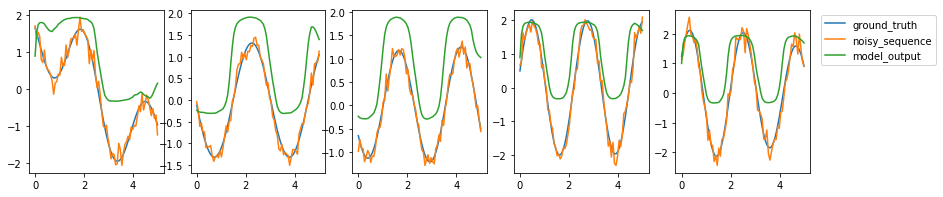

-611.9414% of noise removed.
epoch: 1, train loss:646.3303833007812
epoch: 1, validation loss:1149.0509033203125
epoch: 2, train loss:327.1703796386719
epoch: 2, validation loss:1084.0538330078125
epoch: 3, train loss:226.1516876220703
epoch: 3, validation loss:859.2138671875
epoch: 4, train loss:187.0320281982422
epoch: 4, validation loss:541.1549072265625
epoch: 5, train loss:101.88774871826172
epoch: 5, validation loss:354.93231201171875
epoch: 6, train loss:66.20098114013672
epoch: 6, validation loss:289.7537841796875
epoch: 7, train loss:48.9291877746582
epoch: 7, validation loss:232.10079956054688
epoch: 8, train loss:40.476802825927734
epoch: 8, validation loss:212.60142517089844
epoch: 9, train loss:37.7542610168457
epoch: 9, validation loss:150.28697204589844
epoch: 10, train loss:38.77495193481445
epoch: 10, validation loss:133.10098266601562


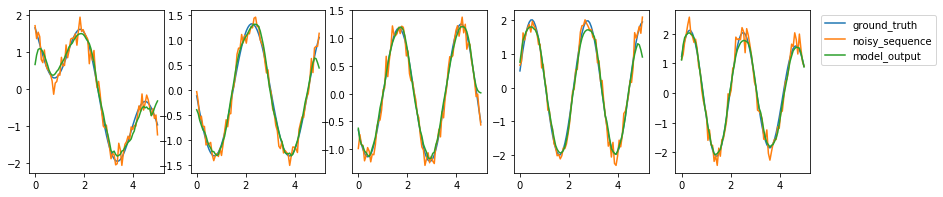

8.5464% of noise removed.
epoch: 11, train loss:28.729045867919922
epoch: 11, validation loss:111.21232604980469
epoch: 12, train loss:21.95695686340332
epoch: 12, validation loss:98.68403625488281
epoch: 13, train loss:25.34083366394043
epoch: 13, validation loss:89.72215270996094
epoch: 14, train loss:19.342716217041016
epoch: 14, validation loss:83.53170013427734
epoch: 15, train loss:20.39744758605957
epoch: 15, validation loss:71.94252014160156
epoch: 16, train loss:17.450485229492188
epoch: 16, validation loss:65.95032501220703
epoch: 17, train loss:16.68866539001465
epoch: 17, validation loss:64.85015869140625
epoch: 18, train loss:15.492079734802246
epoch: 18, validation loss:59.36488342285156
epoch: 19, train loss:13.129616737365723
epoch: 19, validation loss:56.03852462768555
epoch: 20, train loss:12.776308059692383
epoch: 20, validation loss:56.038150787353516


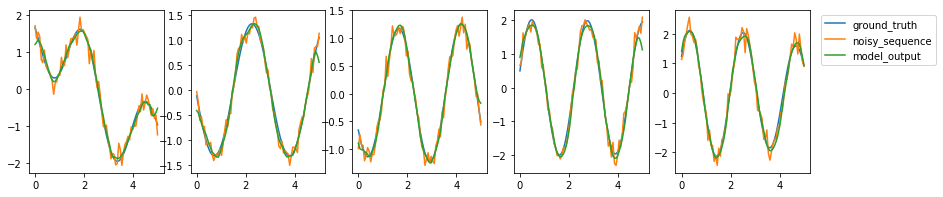

39.9735% of noise removed.
epoch: 21, train loss:12.527524948120117
epoch: 21, validation loss:53.35483932495117
epoch: 22, train loss:13.591517448425293
epoch: 22, validation loss:50.83414077758789
epoch: 23, train loss:14.721138000488281
epoch: 23, validation loss:51.49516677856445
epoch: 24, train loss:13.070616722106934
epoch: 24, validation loss:59.22748947143555
epoch: 25, train loss:12.374776840209961
epoch: 25, validation loss:50.675750732421875
epoch: 26, train loss:13.400781631469727
epoch: 26, validation loss:51.00761032104492
epoch: 27, train loss:12.720378875732422
epoch: 27, validation loss:51.84785461425781
epoch: 28, train loss:11.931355476379395
epoch: 28, validation loss:49.99205017089844
epoch: 29, train loss:10.26573371887207
epoch: 29, validation loss:47.71665573120117
epoch: 30, train loss:10.949254989624023
epoch: 30, validation loss:47.45194625854492


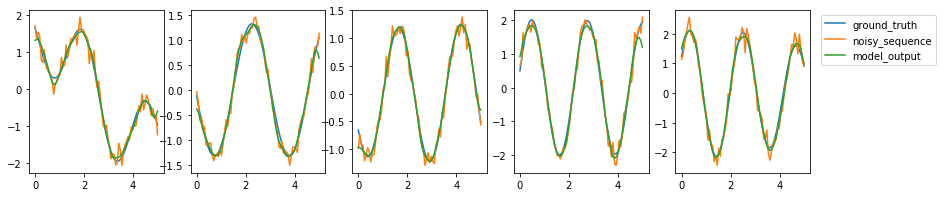

42.8834% of noise removed.
epoch: 31, train loss:10.70362377166748
epoch: 31, validation loss:49.520416259765625
epoch: 32, train loss:9.871487617492676
epoch: 32, validation loss:47.046165466308594
epoch: 33, train loss:10.16430377960205
epoch: 33, validation loss:49.755733489990234
epoch: 34, train loss:10.511070251464844
epoch: 34, validation loss:46.15567398071289
epoch: 35, train loss:11.202898979187012
epoch: 35, validation loss:43.150447845458984
epoch: 36, train loss:10.343198776245117
epoch: 36, validation loss:44.3758430480957
epoch: 37, train loss:11.466636657714844
epoch: 37, validation loss:44.94826889038086
epoch: 38, train loss:12.75462818145752
epoch: 38, validation loss:50.00876998901367
epoch: 39, train loss:14.248414993286133
epoch: 39, validation loss:66.81900787353516
epoch: 40, train loss:13.414749145507812
epoch: 40, validation loss:79.77124786376953


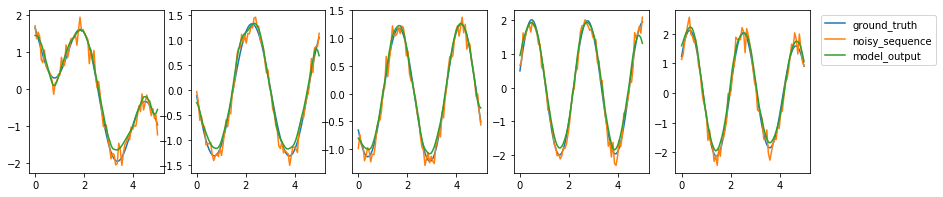

17.2069% of noise removed.
epoch: 41, train loss:11.436677932739258
epoch: 41, validation loss:82.97379302978516
epoch: 42, train loss:10.188450813293457
epoch: 42, validation loss:63.16312026977539
epoch: 43, train loss:13.607488632202148
epoch: 43, validation loss:46.5134162902832
epoch: 44, train loss:12.784192085266113
epoch: 44, validation loss:56.89554977416992
epoch: 45, train loss:13.919901847839355
epoch: 45, validation loss:42.45079803466797
epoch: 46, train loss:10.447893142700195
epoch: 46, validation loss:57.07219314575195
epoch: 47, train loss:16.892793655395508
epoch: 47, validation loss:50.0475959777832
epoch: 48, train loss:19.790483474731445
epoch: 48, validation loss:53.372962951660156
epoch: 49, train loss:14.197152137756348
epoch: 49, validation loss:51.534202575683594
epoch: 50, train loss:12.210670471191406
epoch: 50, validation loss:48.920936584472656


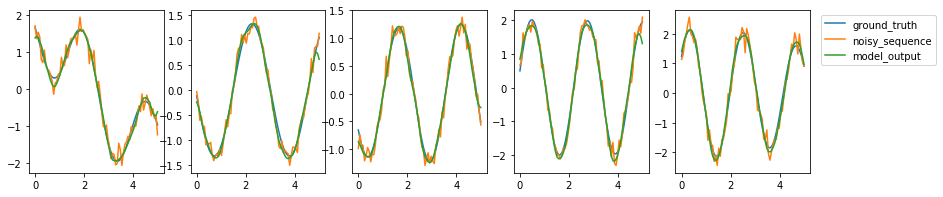

39.0470% of noise removed.
epoch: 51, train loss:10.649497032165527
epoch: 51, validation loss:45.506187438964844
epoch: 52, train loss:8.65700626373291
epoch: 52, validation loss:48.05107116699219
epoch: 53, train loss:7.895230293273926
epoch: 53, validation loss:44.52132797241211
epoch: 54, train loss:8.490596771240234
epoch: 54, validation loss:43.88705062866211
epoch: 55, train loss:7.177988052368164
epoch: 55, validation loss:43.02323532104492
epoch: 56, train loss:6.806879043579102
epoch: 56, validation loss:40.17455291748047
epoch: 57, train loss:7.206820487976074
epoch: 57, validation loss:40.93143844604492
epoch: 58, train loss:6.812915325164795
epoch: 58, validation loss:40.495914459228516
epoch: 59, train loss:7.725510120391846
epoch: 59, validation loss:36.441986083984375
epoch: 60, train loss:8.668428421020508
epoch: 60, validation loss:36.6405143737793


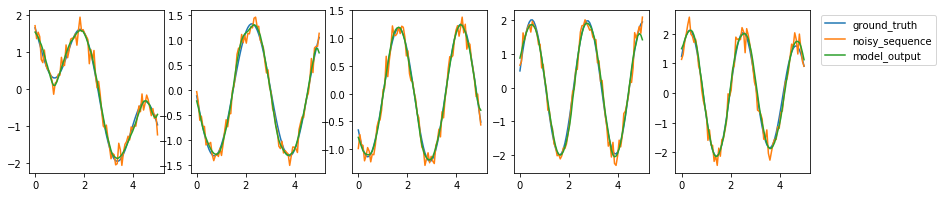

47.8134% of noise removed.
epoch: 61, train loss:8.858606338500977
epoch: 61, validation loss:40.001922607421875
epoch: 62, train loss:7.8427510261535645
epoch: 62, validation loss:44.50835418701172
epoch: 63, train loss:6.460743427276611
epoch: 63, validation loss:45.310001373291016
epoch: 64, train loss:7.170993328094482
epoch: 64, validation loss:41.18952560424805
epoch: 65, train loss:8.269760131835938
epoch: 65, validation loss:36.716041564941406
epoch: 66, train loss:7.900375843048096
epoch: 66, validation loss:39.86965560913086
epoch: 67, train loss:7.362281799316406
epoch: 67, validation loss:42.66020202636719
epoch: 68, train loss:7.577127933502197
epoch: 68, validation loss:37.25044250488281
epoch: 69, train loss:11.192621231079102
epoch: 69, validation loss:42.059715270996094
epoch: 70, train loss:7.8746161460876465
epoch: 70, validation loss:44.427345275878906


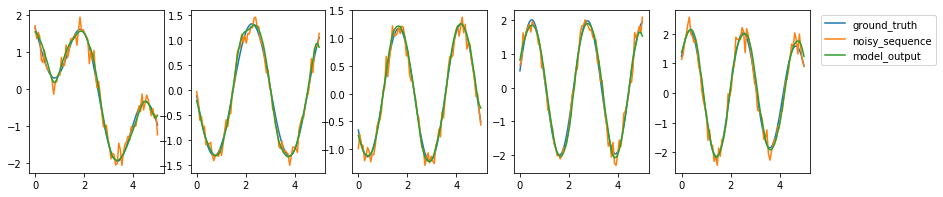

37.8841% of noise removed.
epoch: 71, train loss:7.657918453216553
epoch: 71, validation loss:38.38887405395508
epoch: 72, train loss:7.443288326263428
epoch: 72, validation loss:38.30965042114258
epoch: 73, train loss:7.241878509521484
epoch: 73, validation loss:40.76008605957031
epoch: 74, train loss:5.833873748779297
epoch: 74, validation loss:36.152950286865234
epoch: 75, train loss:6.850775241851807
epoch: 75, validation loss:36.050254821777344
epoch: 76, train loss:6.055478572845459
epoch: 76, validation loss:35.742061614990234
epoch: 77, train loss:5.525870323181152
epoch: 77, validation loss:35.41716766357422
epoch: 78, train loss:6.353301525115967
epoch: 78, validation loss:35.5772705078125
epoch: 79, train loss:6.284037113189697
epoch: 79, validation loss:33.434513092041016
epoch: 80, train loss:5.626562595367432
epoch: 80, validation loss:34.11271667480469


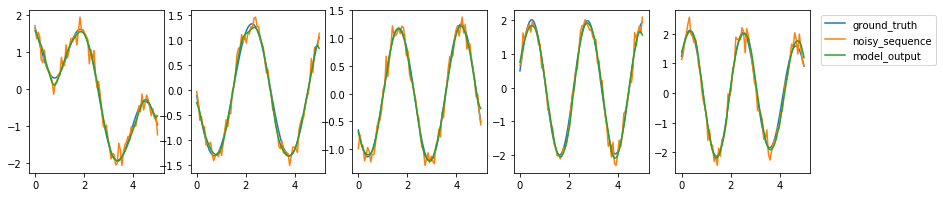

49.4395% of noise removed.
epoch: 81, train loss:5.518814563751221
epoch: 81, validation loss:34.306663513183594
epoch: 82, train loss:5.49846076965332
epoch: 82, validation loss:33.22451400756836
epoch: 83, train loss:5.612481117248535
epoch: 83, validation loss:35.492088317871094
epoch: 84, train loss:5.357431888580322
epoch: 84, validation loss:33.64756393432617
epoch: 85, train loss:5.825057029724121
epoch: 85, validation loss:32.93666458129883
epoch: 86, train loss:5.770074844360352
epoch: 86, validation loss:35.87886047363281
epoch: 87, train loss:5.138582706451416
epoch: 87, validation loss:33.147010803222656
epoch: 88, train loss:5.9174418449401855
epoch: 88, validation loss:33.44744873046875
epoch: 89, train loss:5.537782192230225
epoch: 89, validation loss:34.9138298034668
epoch: 90, train loss:5.080767631530762
epoch: 90, validation loss:33.579444885253906


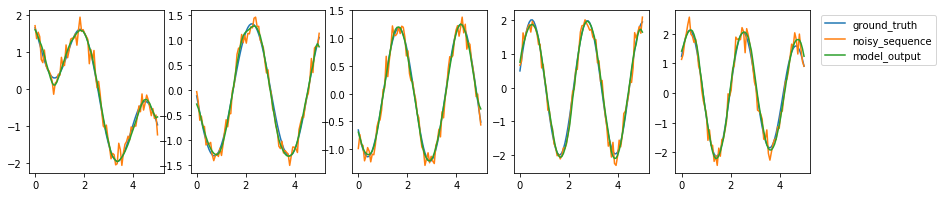

49.5180% of noise removed.
epoch: 91, train loss:5.649721145629883
epoch: 91, validation loss:33.853153228759766
epoch: 92, train loss:5.48385763168335
epoch: 92, validation loss:33.351722717285156
epoch: 93, train loss:5.002500057220459
epoch: 93, validation loss:33.974830627441406
epoch: 94, train loss:5.058722019195557
epoch: 94, validation loss:33.2217903137207
epoch: 95, train loss:5.197115898132324
epoch: 95, validation loss:32.78660583496094
epoch: 96, train loss:4.940092086791992
epoch: 96, validation loss:34.38621520996094
epoch: 97, train loss:5.0294623374938965
epoch: 97, validation loss:32.85543441772461
epoch: 98, train loss:5.3163628578186035
epoch: 98, validation loss:32.92302703857422
epoch: 99, train loss:5.017966270446777
epoch: 99, validation loss:33.8469123840332
epoch: 100, train loss:5.110880374908447
epoch: 100, validation loss:32.993717193603516


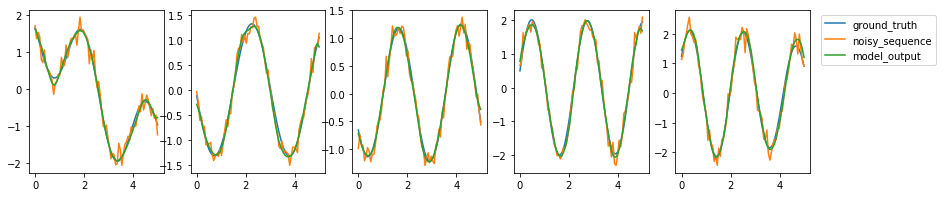

50.4127% of noise removed.
epoch: 101, train loss:5.1893391609191895
epoch: 101, validation loss:33.584224700927734
epoch: 102, train loss:4.8437066078186035
epoch: 102, validation loss:33.038856506347656
epoch: 103, train loss:5.188961029052734
epoch: 103, validation loss:33.16591262817383
epoch: 104, train loss:5.0735063552856445
epoch: 104, validation loss:33.4802360534668
epoch: 105, train loss:4.700207233428955
epoch: 105, validation loss:32.55313491821289
epoch: 106, train loss:4.993151664733887
epoch: 106, validation loss:32.90470504760742
epoch: 107, train loss:4.888505458831787
epoch: 107, validation loss:33.310115814208984
epoch: 108, train loss:4.652583599090576
epoch: 108, validation loss:32.4586181640625
epoch: 109, train loss:4.829691410064697
epoch: 109, validation loss:32.515525817871094
epoch: 110, train loss:4.718621730804443
epoch: 110, validation loss:33.061153411865234


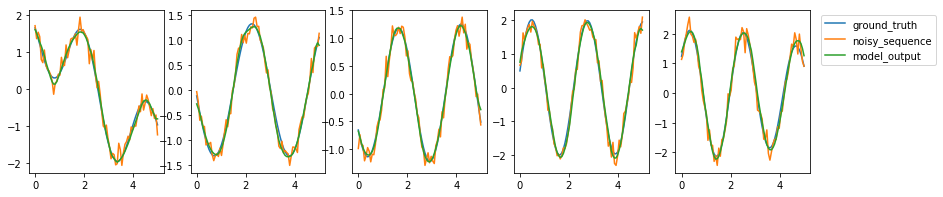

49.7630% of noise removed.
epoch: 111, train loss:4.581546783447266
epoch: 111, validation loss:32.396400451660156
epoch: 112, train loss:4.765264511108398
epoch: 112, validation loss:32.527626037597656
epoch: 113, train loss:4.621934413909912
epoch: 113, validation loss:32.8074951171875
epoch: 114, train loss:4.536728858947754
epoch: 114, validation loss:32.32939529418945
epoch: 115, train loss:4.658188819885254
epoch: 115, validation loss:32.75328826904297
epoch: 116, train loss:4.521697044372559
epoch: 116, validation loss:32.47269058227539
epoch: 117, train loss:4.552054405212402
epoch: 117, validation loss:32.38480758666992
epoch: 118, train loss:4.535816669464111
epoch: 118, validation loss:32.901668548583984
epoch: 119, train loss:4.455356597900391
epoch: 119, validation loss:32.28945541381836
epoch: 120, train loss:4.574785232543945
epoch: 120, validation loss:32.582855224609375


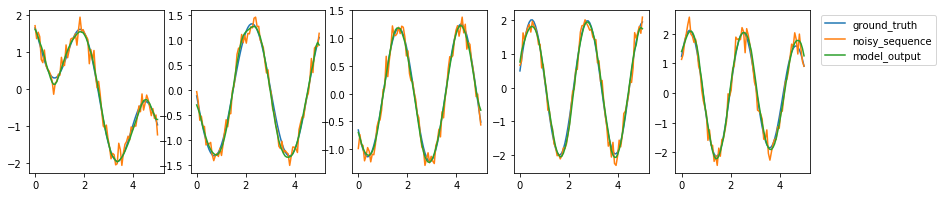

50.5700% of noise removed.
epoch: 121, train loss:4.446084499359131
epoch: 121, validation loss:32.68001937866211
epoch: 122, train loss:4.45429801940918
epoch: 122, validation loss:32.31294631958008
epoch: 123, train loss:4.492456436157227
epoch: 123, validation loss:32.822872161865234
epoch: 124, train loss:4.387689113616943
epoch: 124, validation loss:32.346473693847656
epoch: 125, train loss:4.5038604736328125
epoch: 125, validation loss:32.56736755371094
epoch: 126, train loss:4.37904691696167
epoch: 126, validation loss:32.57857894897461
epoch: 127, train loss:4.3758978843688965
epoch: 127, validation loss:32.26944351196289
epoch: 128, train loss:4.416675567626953
epoch: 128, validation loss:32.770240783691406
epoch: 129, train loss:4.331056594848633
epoch: 129, validation loss:32.310943603515625
epoch: 130, train loss:4.420532703399658
epoch: 130, validation loss:32.53055953979492


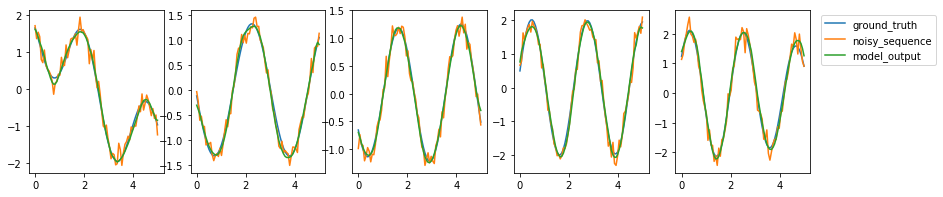

50.6579% of noise removed.
epoch: 131, train loss:4.315008640289307
epoch: 131, validation loss:32.4852180480957
epoch: 132, train loss:4.331746578216553
epoch: 132, validation loss:32.268287658691406
epoch: 133, train loss:4.331454753875732
epoch: 133, validation loss:32.5710563659668
epoch: 134, train loss:4.286753177642822
epoch: 134, validation loss:32.32869338989258
epoch: 135, train loss:4.312976360321045
epoch: 135, validation loss:32.42776107788086
epoch: 136, train loss:4.280044078826904
epoch: 136, validation loss:32.43267059326172
epoch: 137, train loss:4.276475429534912
epoch: 137, validation loss:32.35310745239258
epoch: 138, train loss:4.264779567718506
epoch: 138, validation loss:32.42402267456055
epoch: 139, train loss:4.261790752410889
epoch: 139, validation loss:32.3879280090332
epoch: 140, train loss:4.2382731437683105
epoch: 140, validation loss:32.36084747314453


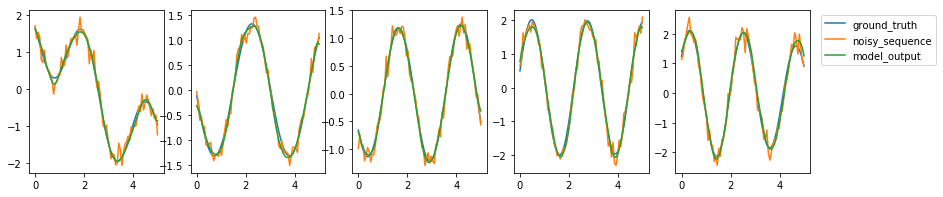

50.9050% of noise removed.
epoch: 141, train loss:4.249547958374023
epoch: 141, validation loss:32.423919677734375
epoch: 142, train loss:4.222419261932373
epoch: 142, validation loss:32.35304260253906
epoch: 143, train loss:4.226718902587891
epoch: 143, validation loss:32.40559768676758
epoch: 144, train loss:4.213574409484863
epoch: 144, validation loss:32.36734390258789
epoch: 145, train loss:4.206336975097656
epoch: 145, validation loss:32.391231536865234
epoch: 146, train loss:4.200580596923828
epoch: 146, validation loss:32.37165451049805
epoch: 147, train loss:4.191742897033691
epoch: 147, validation loss:32.38697052001953
epoch: 148, train loss:4.186144828796387
epoch: 148, validation loss:32.373252868652344
epoch: 149, train loss:4.1783857345581055
epoch: 149, validation loss:32.38321304321289
epoch: 150, train loss:4.172624588012695
epoch: 150, validation loss:32.37481689453125


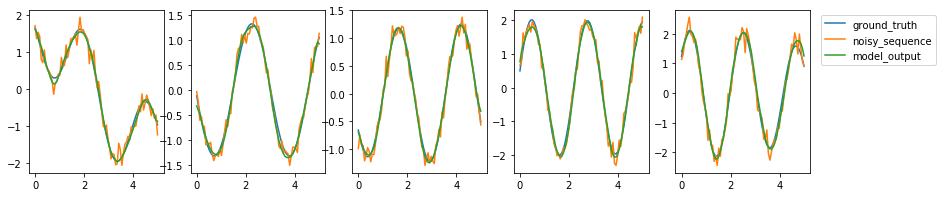

50.9776% of noise removed.
epoch: 151, train loss:4.165428161621094
epoch: 151, validation loss:32.38142013549805
epoch: 152, train loss:4.160429954528809
epoch: 152, validation loss:32.377811431884766
epoch: 153, train loss:4.1531829833984375
epoch: 153, validation loss:32.379459381103516
epoch: 154, train loss:4.1486382484436035
epoch: 154, validation loss:32.381141662597656
epoch: 155, train loss:4.142209053039551
epoch: 155, validation loss:32.38101577758789
epoch: 156, train loss:4.137319087982178
epoch: 156, validation loss:32.382266998291016
epoch: 157, train loss:4.131880283355713
epoch: 157, validation loss:32.38410949707031
epoch: 158, train loss:4.126959800720215
epoch: 158, validation loss:32.384849548339844
epoch: 159, train loss:4.122117519378662
epoch: 159, validation loss:32.386714935302734
epoch: 160, train loss:4.117422103881836
epoch: 160, validation loss:32.388362884521484


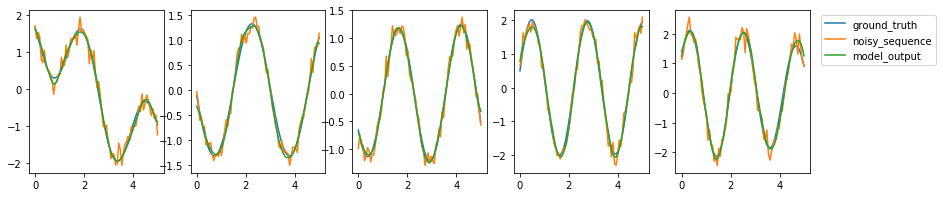

51.0014% of noise removed.
epoch: 161, train loss:4.112945556640625
epoch: 161, validation loss:32.38986587524414
epoch: 162, train loss:4.108616352081299
epoch: 162, validation loss:32.39199447631836
epoch: 163, train loss:4.104483604431152
epoch: 163, validation loss:32.39363098144531
epoch: 164, train loss:4.100459575653076
epoch: 164, validation loss:32.3956298828125
epoch: 165, train loss:4.096660137176514
epoch: 165, validation loss:32.39769744873047
epoch: 166, train loss:4.092988014221191
epoch: 166, validation loss:32.3995246887207
epoch: 167, train loss:4.089471340179443
epoch: 167, validation loss:32.401611328125
epoch: 168, train loss:4.08613920211792
epoch: 168, validation loss:32.40366744995117
epoch: 169, train loss:4.082931995391846
epoch: 169, validation loss:32.40557098388672
epoch: 170, train loss:4.079881191253662
epoch: 170, validation loss:32.40754318237305


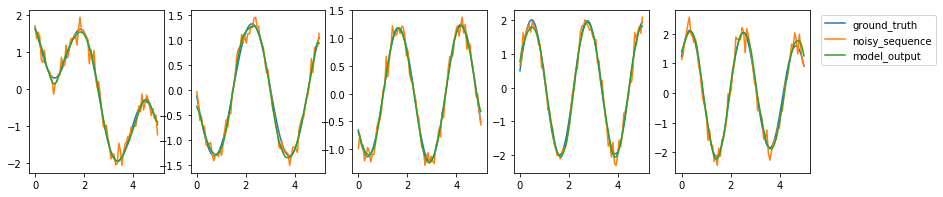

51.0157% of noise removed.
epoch: 171, train loss:4.076993942260742
epoch: 171, validation loss:32.40951919555664
epoch: 172, train loss:4.074242115020752
epoch: 172, validation loss:32.41139221191406
epoch: 173, train loss:4.071630001068115
epoch: 173, validation loss:32.41321563720703
epoch: 174, train loss:4.069163799285889
epoch: 174, validation loss:32.415000915527344
epoch: 175, train loss:4.066833019256592
epoch: 175, validation loss:32.416717529296875
epoch: 176, train loss:4.064637660980225
epoch: 176, validation loss:32.418365478515625
epoch: 177, train loss:4.062572002410889
epoch: 177, validation loss:32.419925689697266
epoch: 178, train loss:4.060636043548584
epoch: 178, validation loss:32.42142105102539
epoch: 179, train loss:4.058826923370361
epoch: 179, validation loss:32.42283248901367
epoch: 180, train loss:4.057137966156006
epoch: 180, validation loss:32.42414093017578


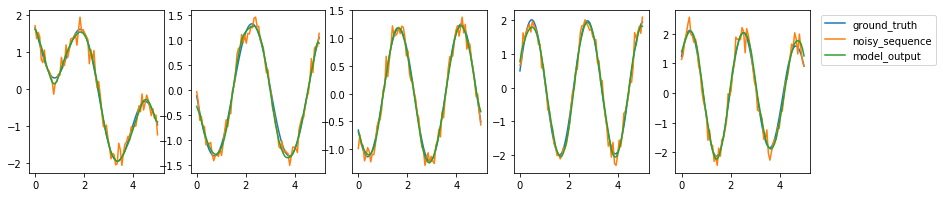

51.0219% of noise removed.
epoch: 181, train loss:4.055566787719727
epoch: 181, validation loss:32.425384521484375
epoch: 182, train loss:4.054114818572998
epoch: 182, validation loss:32.42653274536133
epoch: 183, train loss:4.05277156829834
epoch: 183, validation loss:32.427589416503906
epoch: 184, train loss:4.051537990570068
epoch: 184, validation loss:32.42856216430664
epoch: 185, train loss:4.050410747528076
epoch: 185, validation loss:32.429447174072266
epoch: 186, train loss:4.049382209777832
epoch: 186, validation loss:32.43024444580078
epoch: 187, train loss:4.048449993133545
epoch: 187, validation loss:32.43095779418945
epoch: 188, train loss:4.04761266708374
epoch: 188, validation loss:32.43159103393555
epoch: 189, train loss:4.046865463256836
epoch: 189, validation loss:32.43214797973633
epoch: 190, train loss:4.046201229095459
epoch: 190, validation loss:32.43263626098633


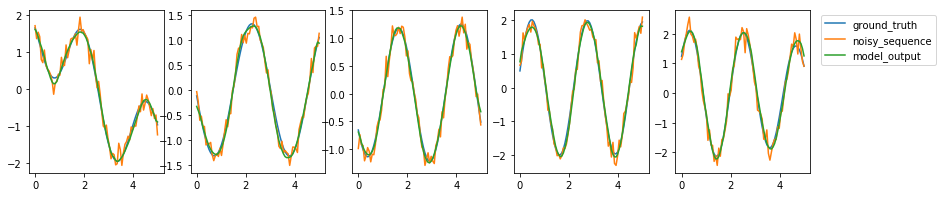

51.0243% of noise removed.
epoch: 191, train loss:4.045619010925293
epoch: 191, validation loss:32.433048248291016
epoch: 192, train loss:4.0451130867004395
epoch: 192, validation loss:32.43339920043945
epoch: 193, train loss:4.044680595397949
epoch: 193, validation loss:32.43367385864258
epoch: 194, train loss:4.044314384460449
epoch: 194, validation loss:32.43390655517578
epoch: 195, train loss:4.04401159286499
epoch: 195, validation loss:32.434078216552734
epoch: 196, train loss:4.043768405914307
epoch: 196, validation loss:32.434207916259766
epoch: 197, train loss:4.043578624725342
epoch: 197, validation loss:32.43429183959961
epoch: 198, train loss:4.0434393882751465
epoch: 198, validation loss:32.4343376159668
epoch: 199, train loss:4.043344020843506
epoch: 199, validation loss:32.43436050415039


In [51]:
# don't forget to create a new model each time!
# START TODO #############

# Configuration 1
batch_size = 20
num_epochs = 101
model = NoiseRemovalModel(hidden_size=40, shift=5)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

# Configuration 2
batch_size = 10
num_epochs = 150
model = NoiseRemovalModel(hidden_size=30, shift=7)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

# Configuration 3
batch_size = 15
num_epochs = 200
model = NoiseRemovalModel(hidden_size=50, shift=5)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

